In [1]:
from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet34
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset, read_pred_csv
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

from torch import Tensor
from collections import OrderedDict, defaultdict
import copy

import os

## Prepare Data path and load cfg

By setting the `L5KIT_DATA_FOLDER` variable, we can point the script to the folder where the data lies.

Then, we load our config file with relative paths and other configurations (rasteriser, training params...).

In [2]:
DEBUG = False

# training cfg
validation_cfg = {
    
    'format_version': 4,
    
     ## Model options
    'model_params': {
        'model_architecture': 'resnet34',
        'history_num_frames': 10,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1,
    },

    ## Input raster parameters
    'raster_params': {
        
        'raster_size': [224, 224], # raster's spatial resolution [meters per pixel]: the size in the real world one pixel corresponds to.
        'pixel_size': [0.5, 0.5], # From 0 to 1 per axis, [0.5,0.5] would show the ego centered in the image.
        'ego_center': [0.25, 0.5],
        'map_type': "py_semantic",
        
        # the keys are relative to the dataset environment variable
        'satellite_map_key': "aerial_map/aerial_map.png",
        'semantic_map_key': "semantic_map/semantic_map.pb",
        'dataset_meta_key': "meta.json",

        # e.g. 0.0 include every obstacle, 0.5 show those obstacles with >0.5 probability of being
        # one of the classes we care about (cars, bikes, peds, etc.), >=1.0 filter all other agents.
        'filter_agents_threshold': 0.5
    },

    ## Data loader options
    'valid_data_loader': {
        'key': "scenes/validate_chopped_100/validate.zarr",
        'batch_size': 1,
        'shuffle': False,
        'num_workers': 0
    },

    ## Valid params
    'valid_params': {
        'checkpoint_every_n_steps': 5000,
        'max_num_steps': 10 if DEBUG else 1000
    }
}

common_cfg = {
    'seed': 500,
    'output_dir': './outputs/1011_2/',
    'epoch': 2,
    'train_step': 5 if DEBUG else 500,
    'valid_step': 5 if DEBUG else 50,
    'train_max': 12,
    'learning_rate': 1e-3
}


In [3]:
OUTPUT_DIR = common_cfg['output_dir']
INPUT_ROOT = Path('/home/knikaido/work/Lyft/data/')
DATA_DIR = INPUT_ROOT / 'lyft-motion-prediction-autonomous-vehicles/'

In [4]:
pred_path1 = f"{OUTPUT_DIR}/pred_1010_custom.csv"
pred_path2 = f"{OUTPUT_DIR}/pred_1109.csv"

In [5]:
eval_gt_path = str(f"{str(DATA_DIR)}/scenes/validate_chopped_100/gt.csv")

In [6]:
metrics = compute_metrics_csv(eval_gt_path, pred_path1, [neg_multi_log_likelihood, time_displace])
for metric_name, metric_mean in metrics.items():
    print(metric_name, metric_mean)

neg_multi_log_likelihood 21.292450470577933
time_displace [0.05084248 0.071258   0.09196249 0.11186268 0.13066574 0.14845368
 0.16635267 0.18443095 0.20266923 0.22092814 0.23897994 0.25724151
 0.27476196 0.29220937 0.30893632 0.32471445 0.33978925 0.35449623
 0.36806612 0.38097483 0.39339918 0.40494897 0.41537411 0.42577392
 0.43625339 0.44565983 0.45506397 0.46375103 0.47314507 0.48080683
 0.48864005 0.49674832 0.50514187 0.51259397 0.52175281 0.53117982
 0.54044545 0.55125288 0.56057263 0.57184003 0.58388352 0.59571358
 0.60843304 0.62222787 0.63725945 0.65273483 0.66902349 0.68685859
 0.70730467 0.72792319]


In [7]:
metrics = compute_metrics_csv(eval_gt_path, pred_path2, [neg_multi_log_likelihood, time_displace])
for metric_name, metric_mean in metrics.items():
    print(metric_name, metric_mean)

neg_multi_log_likelihood 22.192237697292693
time_displace [0.05271462 0.08066927 0.11367393 0.12549967 0.14514339 0.1656306
 0.18650808 0.20282999 0.22003383 0.23987474 0.25708611 0.276436
 0.29295562 0.31267927 0.33030306 0.34523403 0.35937463 0.37702311
 0.38642014 0.40058311 0.41251303 0.423051   0.43125506 0.4431354
 0.45825447 0.46734391 0.47858204 0.48897858 0.50079445 0.50870076
 0.52008806 0.53542303 0.54646484 0.56170121 0.57326597 0.59050311
 0.6018642  0.61195118 0.62378213 0.63490467 0.6440509  0.65929978
 0.67154568 0.68391231 0.70166534 0.71824425 0.73668405 0.75320777
 0.77111646 0.79107088]


In [8]:
ground_truth = OrderedDict()
inference = OrderedDict()

In [9]:
for el in read_gt_csv(eval_gt_path):
    ground_truth[el["track_id"] + el["timestamp"]] = el
for el in read_pred_csv(pred_path1):
    inference[el["track_id"] + el["timestamp"]] = el

In [10]:
metrics_dict = defaultdict(list)

In [11]:
errs = []
for key, ground_truth_value in ground_truth.items():
    gt_coord = ground_truth_value["coord"]
    avail = ground_truth_value["avail"]

    pred_coords = inference[key]["coords"]
    conf = inference[key]["conf"]
#     print(pred_coords.shape)
#     break

    errs.append([key, neg_multi_log_likelihood(gt_coord, pred_coords, conf, avail)])
    
#     break

In [12]:
errs = np.array(errs)

In [13]:
preds = pd.read_csv(pred_path1)
preds['score'] = errs[:, 1]
preds['score'] = pd.to_numeric(preds["score"], errors='coerce')
preds.sort_values('score', ascending=False, inplace=True)
preds.head()

,timestamp,track_id,conf_0,conf_1,conf_2,coord_x00,coord_y00,coord_x01,coord_y01,coord_x02,...,coord_y245,coord_x246,coord_y246,coord_x247,coord_y247,coord_x248,coord_y248,coord_x249,coord_y249,score
40042,1578602476102789726,275,0.165925,0.038380,0.795695,0.026783,-0.013054,0.038478,-0.024848,0.050538,...,0.218190,-0.080219,0.222762,-0.097391,0.228518,-0.118748,0.235422,-0.142247,0.243123,26000.203730
64756,1580322241102974836,8,0.021928,0.002918,0.975154,0.015104,-0.001592,0.021191,-0.003781,0.026578,...,0.019076,0.023626,0.020364,0.020017,0.024010,0.013921,0.029681,0.006515,0.036524,14900.730516
5912,1576265458302774716,595,0.236348,0.016855,0.746797,-0.000819,0.028032,-0.028944,0.049125,-0.054605,...,0.313389,-0.858075,0.312199,-0.849320,0.308156,-0.837871,0.302245,-0.825625,0.295893,12990.118914
1515,1575390774903426396,7,0.043893,0.009306,0.946801,-0.026026,0.009365,-0.027447,0.024909,-0.031192,...,0.319190,-0.215621,0.324584,-0.218547,0.325253,-0.219752,0.322166,-0.220133,0.317059,12819.862497
85166,1583342242302586046,7,0.015634,0.002480,0.981887,-0.001167,-0.018160,-0.017744,-0.023624,-0.033305,...,-0.036606,-0.175387,-0.032945,-0.169917,-0.028781,-0.159616,-0.024172,-0.146678,-0.019355,11973.851918


In [14]:
for key, ground_truth_value in ground_truth.items():
    if(ground_truth_value["timestamp"] == '1584140326702765166' and ground_truth_value["track_id"] == '1'):
        gt_coord = ground_truth_value["coord"]
        avail = ground_truth_value["avail"]
        pred_coords = inference[key]["coords"]
        conf = inference[key]["conf"]
        print(conf)
        print(neg_multi_log_likelihood(gt_coord, pred_coords, conf, avail))
        conf = np.array([1, 0, 0])
        print(neg_multi_log_likelihood(gt_coord, pred_coords, conf, avail))
        conf = np.array([0, 1, 0])
        print(neg_multi_log_likelihood(gt_coord, pred_coords, conf, avail))
        conf = np.array([0, 0, 1])
        print(neg_multi_log_likelihood(gt_coord, pred_coords, conf, avail))

        break

[0.02167379 0.00784627 0.97048   ]
0.15614216925932406
116.92602846569557
793.750730011586
0.12617768473985086


In [15]:
np.max(gt_coord[:, 0]) -np.min(gt_coord[:, 0]), np.max(gt_coord[:, 1]) -np.min(gt_coord[:, 1])

(0.046259999999999996, 0.042120000000000005)

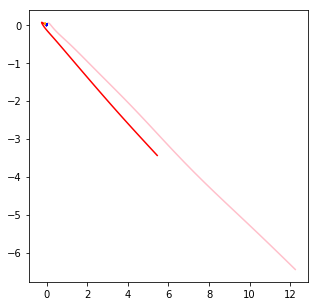

In [16]:
fig = plt.figure(figsize=(5,5))
pred_ = pred_coords[0].transpose(1,0)
plt.plot(pred_[0], pred_[1], color='red')
pred_ = pred_coords[1].transpose(1,0)
plt.plot(pred_[0], pred_[1], color='pink')
pred_ = pred_coords[2].transpose(1,0)
plt.plot(pred_[0], pred_[1], color='orange')
gt_coord_ = gt_coord.transpose(1,0)
plt.plot(gt_coord_[0], gt_coord_[1], color='blue')

In [17]:
count = 0

for key, ground_truth_value in ground_truth.items():
    gt_coord = ground_truth_value["coord"]
    avail = ground_truth_value["avail"]
    pred_coords = inference[key]["coords"]
    conf = inference[key]["conf"]
    if(np.max(gt_coord[:, 0])-np.min(gt_coord[:, 0])<=0.2):
        if(np.max(gt_coord[:, 1]) -np.min(gt_coord[:, 1])<=0.2):
            
            count += 1
count
            

25343

In [18]:
avail_ = np.ones(50)
conf_ = np.array([1, 0, 0])
gt_coord_ = gt_coord
pred_coords_ = np.zeros([3, 50, 2])
neg_multi_log_likelihood(gt_coord_, pred_coords_, conf_, avail_)

38926.19807847765

In [19]:
timestamps = []
track_id = []
coords = []
for key, ground_truth_value in ground_truth.items():
    timestamps.append(ground_truth_value["timestamp"])
    track_id.append(ground_truth_value["track_id"])
    coords.append(np.array(ground_truth_value["coord"]).reshape(-1))

In [20]:
grands = np.hstack([np.array(timestamps).reshape(94694, 1), np.array(track_id).reshape(94694, 1), np.array(coords)])

In [21]:
grands = pd.DataFrame(grands)
grands[0] = grands[0].astype('int')
grands[1] = grands[1].astype('int')
# grands[2:] = grands[2:].astype('float32')
grands.sort_values([0, 1], inplace=True)
grands.reset_index(inplace=True, drop=True)

grands.head(20)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
0,1574364399902601396,1,0.33936,0.74268,0.70551,1.53467,1.08331,2.30396,1.44617,3.03198,...,13.99939,24.84814,14.16577,25.12769,14.29993,25.33227,14.48065,25.58081,14.59912,25.78589
1,1574364399902601396,3,0.41217,0.73145,0.73926,1.47388,1.19312,2.31079,1.57062,3.02734,...,14.36835,29.39649,14.43591,29.48804,14.75617,29.98047,14.81647,30.15405,14.92841,30.39551
2,1574364424902827486,2,0.7041,1.06958,1.39423,2.1604,2.11395,3.24146,2.84698,4.3186,...,31.93659,48.91235,32.66449,49.99536,33.34552,51.06836,34.07605,52.18433,34.78174,53.19434
3,1574364449901934626,836,-0.37897,-0.46472,-0.73987,-0.98987,-1.09082,-1.47876,-1.474,-2.02673,...,-21.45233,-31.79517,-21.87238,-32.43933,-22.29443,-33.10413,-22.97937,-34.17895,-23.53534,-35.03333
4,1574364474902117814,1,0.63397,0.99182,1.26569,2.00659,1.87195,3.05762,2.51581,4.06567,...,14.88104,48.82288,14.90655,49.84509,14.88788,50.95251,14.8476,51.96265,14.83209,53.04138
5,1574364515202921606,1,-0.67303,0.43787,-1.35413,0.85889,-2.02203,1.28528,-2.65137,1.68848,...,-27.64539,17.75562,-28.01971,18.01965,-28.48596,18.32141,-28.91467,18.57788,-29.33417,18.82642
6,1574364515202921606,4,-0.00122,-0.01929,-0.00867,-0.00293,0.0105,0.00525,0.01563,0.01868,...,-1.41486,0.87793,-1.35352,0.83545,-1.34033,0.8175,-1.50983,0.94299,-1.61908,1.02808
7,1574364515202921606,374,0.8548,-0.45923,1.7525,-0.94495,2.68579,-1.45532,3.63898,-1.98633,...,40.63172,-23.74732,41.43311,-24.24658,42.19183,-24.70483,42.93121,-25.15454,43.63147,-25.54126
8,1574364515202921606,405,0.58502,-0.35413,1.16345,-0.71301,1.76062,-1.0564,2.33685,-1.41968,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1574364515202921606,431,0.51733,-0.33081,1.05048,-0.66565,1.61774,-1.01123,2.15399,-1.35022,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
pred_pathes = [pred_path1, pred_path2]
outputs = []
for path in pred_pathes:
    output = pd.read_csv(path)
    output.sort_values(['timestamp', 'track_id'], inplace=True)
    output.reset_index(inplace=True, drop=True)
    outputs.append(output)


In [49]:
t_predicts = []
t_confs = []

In [24]:
for i in tqdm(range(94694)):
    predicts = []
    confs = []
    for output in outputs:
        confs.append(output.loc[i, 'conf_0'])
        confs.append(output.loc[i, 'conf_1'])
        confs.append(output.loc[i, 'conf_2'])
        predicts.append(output.loc[i, 'coord_x00':'coord_y049'].values)
        predicts.append(output.loc[i, 'coord_x10':'coord_y149'].values)
        predicts.append(output.loc[i, 'coord_x20':'coord_y249'].values)
    t_predicts.append(predicts)
    t_confs.append(confs)

100%|██████████| 94694/94694 [04:12<00:00, 375.73it/s]


In [25]:
index = 2312
grand_coord = grands.loc[index, 2:].astype('float32').values
tmp_conf = t_confs[index]
tmp_predicts = t_predicts[index]

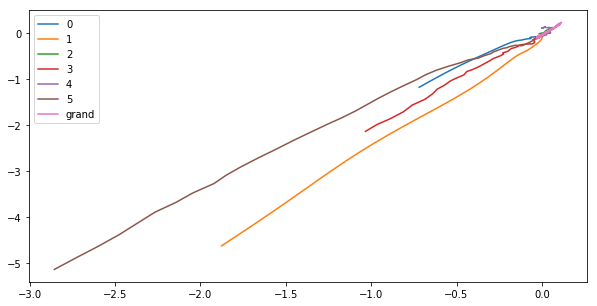

In [26]:
fig = plt.figure(figsize=(10, 5))
plt.plot(tmp_predicts[0][::2], tmp_predicts[0][1::2], label="0")
plt.plot(tmp_predicts[1][::2], tmp_predicts[1][1::2], label="1")
plt.plot(tmp_predicts[2][::2], tmp_predicts[2][1::2], label="2")
plt.plot(tmp_predicts[3][::2], tmp_predicts[3][1::2], label="3")
plt.plot(tmp_predicts[4][::2], tmp_predicts[4][1::2], label="4")
plt.plot(tmp_predicts[5][::2], tmp_predicts[5][1::2], label="5")
plt.plot(grand_coord[::2], grand_coord[1::2], label="grand")
plt.legend()

In [27]:
tmp_conf

[0.042087153,
 0.0071843494999999985,
 0.9507285,
 0.033749282,
 0.9581745,
 0.008076228000000001]

In [28]:
predicts1 = []
predicts1.extend(tmp_predicts[0])
predicts1.extend(tmp_predicts[1])
predicts1.extend(tmp_predicts[2])
conf1 = np.array([tmp_conf[0], tmp_conf[1], tmp_conf[2]])

In [29]:
neg_multi_log_likelihood(grand_coord.reshape(50, 2), np.array(predicts1).reshape(3, 50, 2), conf1, np.array([1]*50))

0.5470084929643525

In [30]:
predicts2 = []
predicts2.extend(tmp_predicts[3])
predicts2.extend(tmp_predicts[4])
predicts2.extend(tmp_predicts[5])
conf2 = np.array([tmp_conf[3], tmp_conf[4], tmp_conf[5]])

In [31]:
neg_multi_log_likelihood(grand_coord.reshape(50, 2), np.array(predicts2).reshape(3, 50, 2), conf2, np.array([1]*50))

0.4858649631293035

In [32]:
tmp_predicts_con = []
tmp_predicts_con.extend(tmp_predicts[1])
tmp_predicts_con.extend([0]*100)
tmp_predicts_con.extend([0]*100)

In [33]:
neg_multi_log_likelihood(grand_coord.reshape(50, 2), np.array(tmp_predicts_con).reshape(3, 50, 2), np.array([1, 0, 0]), np.array([1]*50))

101.19526786209383

In [34]:
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


In [35]:
def calc_distance(coord1, coord2):
    coord1 = coord1.reshape(-1, 2)
    coord2= coord2.reshape(-1, 2)
    distance = 0
    cos = 0
    for i in range(len(coord1)):
        cos += cos_sim(coord2[i], coord1[i])
        distance += pow(coord2[i, 0] - coord1[i, 0], 2) + pow(coord2[i, 1] - coord1[i, 1], 2)
        
    return cos / len(coord1), np.sqrt(distance)
    

In [36]:
def decide_preds(tmp_predicts, tmp_conf, thre=30):
    
    
    predicts = copy.deepcopy(tmp_predicts)
    confs = copy.deepcopy(tmp_conf)
    
    ans_preds = []
    ans_confs = []
    
    for i in range(3):
        ind = np.argmax(confs)
        pre1 = predicts[ind]
        ans_preds.append(pre1)
        ans_confs.append(confs[ind])
        predicts.pop(ind)
        confs.pop(ind)

        predicts_ = []
        confs_ = []
        for i in range(len(predicts)):
            angle, dist = calc_distance(pre1, np.array(predicts[i]))
            if(dist > thre):
                predicts_.append(predicts[i])
                confs_.append(confs[i])
                
        if(len(confs_)<3):
            return tmp_predicts[0:3], tmp_conf[0:3] / np.sum(tmp_conf[0:3])
            
        predicts = predicts_
        confs = confs_
        
    ans_confs = ans_confs / np.sum(ans_confs)
    return ans_preds, ans_confs
        

In [37]:
np.argmax(tmp_conf)

4

In [38]:
ans_preds, ans_confs = decide_preds(tmp_predicts, tmp_conf)

In [39]:
predicts2 = []
predicts2.extend(ans_preds[0])
predicts2.extend(ans_preds[1])
predicts2.extend(ans_preds[2])
conf2 = np.array([ans_confs[0], ans_confs[1], ans_confs[2]])

In [40]:
neg_multi_log_likelihood(grand_coord.reshape(50, 2), np.array(predicts2).reshape(3, 50, 2), conf2, np.array([1]*50))

0.5470084954643525

In [41]:
# for i in range(len(t_confs)):
#     for j in range(3):
# #         t_confs[i][j] = t_confs[i][j] * 2  
#         t_confs[i][j] = t_confs[i][j] * 10 * (21.7 / 21.3)  

In [42]:
ans_output = pd.read_csv(str(OUTPUT_DIR)+'pred_1010.csv')
ans_output.sort_values(['timestamp', 'track_id'], inplace=True)
ans_output.reset_index(inplace=True, drop=True)
ans_conf = ans_output.loc[:, 'conf_0':'conf_2']
ans_coord= ans_output.loc[:, 'coord_x00':]

In [43]:
for j in tqdm(range(len(ans_output))):
    prepre, concon = decide_preds(t_predicts[j], t_confs[j])

    ans_conf.iloc[j] = concon
    ans_coord.iloc[j] = np.array(prepre).reshape(-1)


100%|██████████| 94694/94694 [06:32<00:00, 241.48it/s]


In [44]:
ans_output.loc[:, 'conf_0':'conf_2'] = ans_conf
ans_output.loc[:, 'coord_x00':] = ans_coord

In [45]:
ans_output.to_csv(str(OUTPUT_DIR)+'pred_ansamble.csv', index=False)
pred_path_ = str(OUTPUT_DIR)+'pred_ansamble.csv'
ans_output

,timestamp,track_id,conf_0,conf_1,conf_2,coord_x00,coord_y00,coord_x01,coord_y01,coord_x02,...,coord_x245,coord_y245,coord_x246,coord_y246,coord_x247,coord_y247,coord_x248,coord_y248,coord_x249,coord_y249
0,1574364399902601396,1,0.452226,0.174998,0.372776,0.352950,0.768407,0.703219,1.500859,1.054638,...,14.039252,25.233285,14.249384,25.522800,14.455089,25.805094,14.659608,26.085474,14.866672,26.369638
1,1574364399902601396,3,0.423236,0.182002,0.394762,0.432038,0.845263,0.846765,1.688959,1.261487,...,14.602966,29.482602,14.833410,29.927132,15.058813,30.361709,15.282684,30.792851,15.508991,31.228273
2,1574364424902827486,2,0.419648,0.186097,0.394255,0.681790,1.085086,1.404457,2.185226,2.126384,...,31.973179,48.609641,32.627200,49.608317,33.273555,50.597053,33.919056,51.585424,34.571631,52.584600
3,1574364449901934626,836,0.506082,0.322601,0.171317,-0.335677,-0.449166,-0.687134,-0.913975,-1.038315,...,-13.896561,-15.387691,-14.151020,-15.598765,-14.398628,-15.808804,-14.643038,-16.020653,-14.888909,-16.236923
4,1574364474902117814,1,0.514791,0.206952,0.278257,0.556707,0.942090,1.145457,1.933617,1.730301,...,14.984266,45.990126,14.995755,47.001849,14.997587,47.999403,14.994586,48.993612,14.991583,49.997492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94689,1584140351702477836,8,0.313687,0.095161,0.591152,-0.571036,-0.948232,-1.178492,-1.936991,-1.787196,...,-31.030810,-48.008019,-31.725901,-49.048264,-32.413619,-50.078583,-33.100743,-51.108820,-33.795191,-52.150332
94690,1584140451301713374,364,0.433969,0.165961,0.400070,0.890398,1.391600,1.822207,2.812443,2.753794,...,40.081914,60.863457,40.876519,62.075109,41.658724,63.268873,42.437688,64.458029,43.224263,65.658755
94691,1584140451301713374,494,0.156610,0.122359,0.721032,-0.474307,0.208232,-0.809236,0.368275,-1.142500,...,-2.616352,5.680029,-2.655261,5.849392,-2.711754,6.034628,-2.781846,6.232895,-2.858884,6.439287
94692,1584140476302704606,1,0.476880,0.294178,0.228943,-0.377475,-0.574794,-0.741325,-1.154883,-1.106062,...,-15.547317,-19.589209,-15.838303,-19.881223,-16.125991,-20.170211,-16.413475,-20.459550,-16.704378,-20.752888


In [46]:
metrics = compute_metrics_csv(eval_gt_path, pred_path_, [neg_multi_log_likelihood, time_displace])
for metric_name, metric_mean in metrics.items():
    print(metric_name, metric_mean)

neg_multi_log_likelihood 21.27570091927767
time_displace [0.05084863 0.0712765  0.09196585 0.11183837 0.13061975 0.14839021
 0.16630666 0.18438493 0.20260494 0.22085183 0.2388868  0.25719889
 0.27473467 0.29220123 0.30899962 0.3247465  0.33988137 0.35459066
 0.36809555 0.38099601 0.39337799 0.40487711 0.41529987 0.42568292
 0.43610446 0.44550439 0.4549019  0.46348944 0.47287396 0.4805276
 0.4883065  0.49641293 0.50478531 0.51222376 0.52131545 0.53072617
 0.53997809 0.55076255 0.56001355 0.57132697 0.58344578 0.59526822
 0.60798226 0.6217683  0.63694042 0.65241779 0.66870841 0.68654278
 0.70698824 0.72750642]


In [47]:
neg_multi_log_likelihood 21.234776685153225

SyntaxError: invalid syntax (<ipython-input-47-24cc5f676833>, line 1)

In [48]:
26.188473004283985

26.188473004283985